In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from ieeg.auth import Session
import os
from numbers import Number
import pyedflib
import warnings
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
import scipy as sc
warnings.filterwarnings("ignore")
from scipy import signal as sig
from scipy.ndimage import uniform_filter1d
from tqdm import tqdm
import re
from utils_baseline import get_iEEG_data, preprocess
from scipy.ndimage import gaussian_filter1d
seizure_list = pd.read_csv('/mnt/sauce/littlab/users/kuangzy/SeizureOnsetDetection/revised_emu_seizure_sheet.csv')


# training and evaluation

## one example

In [100]:
sz_row = seizure_list.iloc[109,:]
print(f"Pulling seizure from {sz_row.patient}: {sz_row.fname} from {sz_row.start} to {sz_row.end}")
sz_df, fs_raw = get_iEEG_data('joie1','/mnt/sauce/littlab/users/kuangzy/ieeglogin.bin',
                              sz_row.fname,sz_row.start*1e6,sz_row.end*1e6, 
                              select_electrodes=['C3', 'C4', 'F3', 'F4', 'F7', 'F8', 'Fp1', 'Fp2', 'O1', 
                                                'O2', 'P3', 'P4', 'T3', 'T4', 'T5', 'T6'])
sz_montage = preprocess(sz_df,fs_raw,
                        current_channel_order = ['C3', 'C4', 'F3', 'F4', 'F7', 'F8', 'Fp1', 'Fp2', 
                         'O1', 'O2', 'P3', 'P4', 'T3', 'T4', 'T5', 'T6'],
                        new_channel_order = ['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 
                        'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2'],
                        bipolar_channels = ['Fp1-F7', 'F7-T3', 'T3-T5', 'T5-O1', 'Fp2-F8', 'F8-T4', 'T4-T6', 'T6-O2', 
                        'Fp1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'Fp2-F4', 'F4-C4', 'C4-P4', 'P4-O2'])
interictal = sz_montage[:int(60*200)]


Pulling seizure from EMU1835: EMU1835_Event_Day07_1 from 26234.375 to 26648.4375


In [101]:
from utils_baseline import extract_features, train_one_class_svm, compute_novelty_scores, estimate_outlier_fraction,detect_seizure,apply_persistence
X_train = extract_features(interictal)
clf = train_one_class_svm(X_train)
X_test = extract_features(sz_montage)
y_pred = compute_novelty_scores(clf, X_test)

nu_hat = estimate_outlier_fraction(y_pred, n=20)
nu_filt = np.round(gaussian_filter1d(nu_hat,2*int(len(nu_hat)/1000+1)),100)
z = detect_seizure(nu_hat, threshold=0.9)
z_filtered = apply_persistence(z)
print(f'the predicted onset is {np.where(z_filtered)[0][0]/2-(sz_row.onset-sz_row.start)} seconds later than the true onset')

the predicted onset is 14.777343999998266 seconds later than the true onset


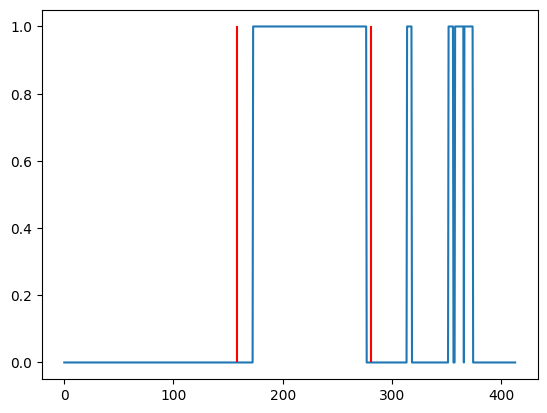

In [102]:
time = np.arange(0,sz_row.end-sz_row.start-1,0.5)
plt.plot(time,z)
plt.vlines([sz_row.onset-sz_row.start,sz_row.offset-sz_row.start],0,1,'r')

# test on all data

In [103]:
def detect_onset(idx):
    sz_row = seizure_list.iloc[idx,:]
    #print(f"Pulling seizure from {sz_row.patient}: {sz_row.fname} from {sz_row.start} to {sz_row.end}")
    sz_df, fs_raw = get_iEEG_data('joie1','/mnt/sauce/littlab/users/kuangzy/ieeglogin.bin',
                                sz_row.fname,sz_row.start*1e6,sz_row.end*1e6, 
                                select_electrodes=['C3', 'C4', 'F3', 'F4', 'F7', 'F8', 'Fp1', 'Fp2', 'O1', 
                                                    'O2', 'P3', 'P4', 'T3', 'T4', 'T5', 'T6'])
    sz_montage = preprocess(sz_df,fs_raw,
                            current_channel_order = ['C3', 'C4', 'F3', 'F4', 'F7', 'F8', 'Fp1', 'Fp2', 
                            'O1', 'O2', 'P3', 'P4', 'T3', 'T4', 'T5', 'T6'],
                            new_channel_order = ['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 
                            'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2'],
                            bipolar_channels = ['Fp1-F7', 'F7-T3', 'T3-T5', 'T5-O1', 'Fp2-F8', 'F8-T4', 'T4-T6', 'T6-O2', 
                            'Fp1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'Fp2-F4', 'F4-C4', 'C4-P4', 'P4-O2'])
    interictal = sz_montage[:int(60*200)]
    X_train = extract_features(interictal)
    X_train = np.nan_to_num(X_train, nan=0.0, posinf=1e6, neginf=-1e6)
    clf = train_one_class_svm(X_train)
    X_test = extract_features(sz_montage)
    X_test = np.nan_to_num(X_test, nan=0.0, posinf=1e6, neginf=-1e6)
    y_pred = compute_novelty_scores(clf, X_test)
    nu_hat = estimate_outlier_fraction(y_pred, n=10)
    nu_filt = np.round(gaussian_filter1d(nu_hat,2*int(len(nu_hat)/1000+1)),100)
    z = detect_seizure(nu_filt, threshold=0.9)
    z_filtered = apply_persistence(z)
    if np.where(z_filtered)[0].shape[0]>0:
        latency = np.where(z_filtered)[0][0]/2-(sz_row.onset-sz_row.start)
        #print(f'the predicted onset is {latency} seconds later than the true onset')
        return latency, z
    else:
        return np.nan, z

In [104]:
diff = []
class_pred = []
for i in tqdm(range(len(seizure_list))):
    latency, z = detect_onset(i)
    diff.append(latency)
    class_pred.append(z)
with open("diff_baseline.txt", 'w') as f:
    for s in diff:
        f.write(str(s) + '\n')

  0%|          | 0/449 [00:00<?, ?it/s]

100%|██████████| 449/449 [22:20<00:00,  2.98s/it]


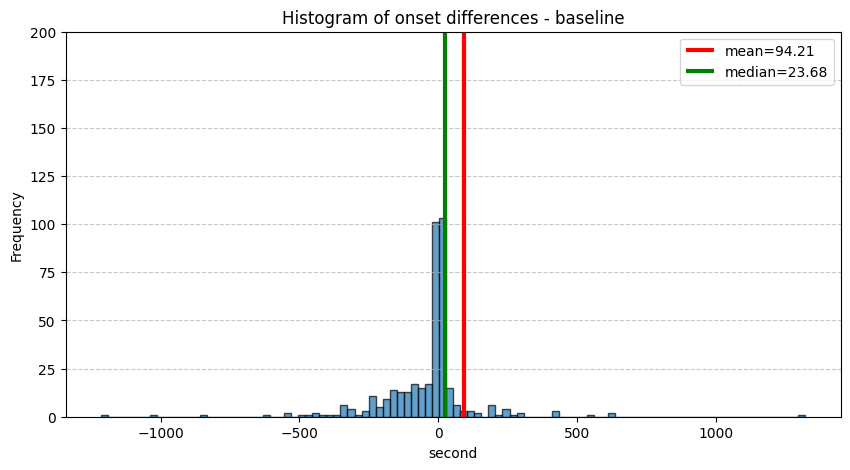

In [105]:
def plot_histogram(data, bins, title="Histogram of onset differences - baseline", xlabel="second", ylabel="Frequency"):
    mean_value = np.nanmean(np.abs(data))
    median_value = np.nanmedian(np.abs(data))
    plt.figure(figsize=(10, 5))
    counts, bin_edges, _ = plt.hist(data, bins=bins, edgecolor="black", alpha=0.7)
    #plt.xticks(bin_edges)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.vlines(np.nanmean(np.abs(data)),0,200,colors='r', linewidth= 3,label=f'mean={mean_value:.2f}')
    plt.vlines(np.nanmedian(np.abs(data)),0,200,colors='g',linewidth= 3,label=f'median={median_value:.2f}')
    plt.legend()
    plt.ylim(0,200)
    plt.show()
    

# Example usage
plot_histogram(diff, bins=100)

Text(0.5, 1.0, 'Normalized Confusion Matrix of SPaRCNet')

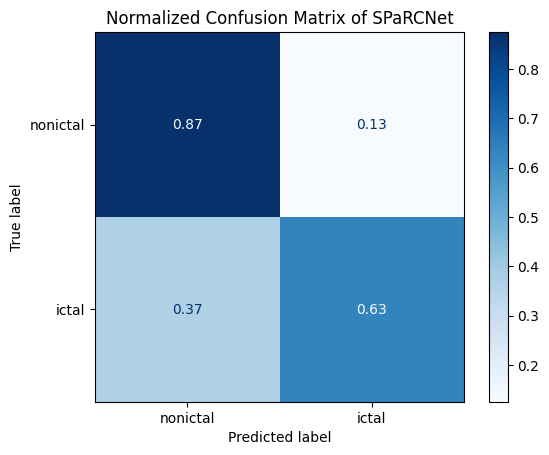

In [107]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
true,predicted = [], []
for i in range(449):
    sz_row = seizure_list.iloc[i]
    length = sz_row.end - sz_row.start
    label = np.arange(len(class_pred[i]))
    on_idx = (sz_row.onset - sz_row.start)*2
    off_idx = (sz_row.offset - sz_row.start)*2
    true += [1 if l <= off_idx and l>=on_idx else 0 for l in label]
    predicted += [1 if p>=0.5 else 0 for p in class_pred[i]]

cm = confusion_matrix(true, predicted, labels=[0,1], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['nonictal','ictal'])

disp.plot(cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix of SPaRCNet')